In [1]:
from functools import reduce
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
dataset_name = 'retail.txt'
patterns_name = 'patterns.csv'
rules_name = 'rules.csv'
maximal_name = 'maximal.csv'
min_support = 0.0015
min_confidence = 0.9

In [3]:
dataset = open(dataset_name, "r").readlines()
T = []
for line in dataset:
    T.append(line.strip().split(" "))

In [4]:
def vertical_format(db):
    result = {}
    result[frozenset()] = set()
    for id, row in enumerate(db):
        id_set = set([id])
        result[frozenset()] |= id_set
        for i in row:
            key = frozenset([i])
            result[key] = result.get(key, set()) | id_set
    return result

In [5]:
num_transactions = len(T)
items = reduce(lambda x, y: frozenset(x) | frozenset(y), T)
items = [frozenset([i]) for i in items]
db = vertical_format(T)

In [6]:
def eclat_paper(single_items,items,tid,k,min_support,can,itr):
    t0 = time.time()
    can_incr = 0
    counter = 0
    T = []
    T_set = set()
    for (i, Ai) in enumerate(items):
        if len(tid[Ai]) / num_transactions >= min_support:
            counter += 1
            f.write('-'.join(list(Ai)) + ',' + str(len(tid[Ai])) + ','
                    + str(len(tid[Ai]) / num_transactions) + '\n')
        else:
            continue
        for (j, Aj) in enumerate(single_items):
            if j <= i or len(Ai | Aj) != k:
                continue
            can_incr += 1
            temp = tid[Ai] & tid[Aj]
            if len(temp) / num_transactions >= min_support and Ai | Aj not in T_set:
                tid[Ai | Aj] = tid[Ai] & tid[Aj]
                T_set.add(Ai | Aj)
                T.append(Ai | Aj)
    if counter > 0:
        can.append(can_incr)
        k += 1
        t1 = time.time()
        print('Iteration ' + str(itr) + ':' )
        print('  - execution time: ' + str(t1 - t0) + ' seconds')
        print('  - candidates: ' + str(can[itr - 1]))
        print('  - frequent itemsets: ' + str(counter))
        itr += 1
        eclat_paper(single_items,T,tid,k,min_support,can,itr,)

In [7]:
itr = 1
can = []
can.append(len(items))
k = 2
f = open(patterns_name, 'w+')
eclat_paper(items,items,db,k,min_support,can,itr)
f.close()

Iteration 1:
  - execution time: 29.092487573623657 seconds
  - candidates: 16470
  - frequent itemsets: 1350
Iteration 2:
  - execution time: 76.70855379104614 seconds
  - candidates: 11335841
  - frequent itemsets: 1848
Iteration 3:
  - execution time: 37.80469250679016 seconds
  - candidates: 28724388
  - frequent itemsets: 857
Iteration 4:
  - execution time: 5.494015216827393 seconds
  - candidates: 13744566
  - frequent itemsets: 170
Iteration 5:
  - execution time: 0.3510708808898926 seconds
  - candidates: 2784685
  - frequent itemsets: 12


In [8]:
def superset(fp,maximal):
    for i in maximal:
        if fp.issubset(i):
            return True
    return False

In [9]:
def find_maximal(patterns_name,min_support,num_transactions):
    f = open(maximal_name,"w+")
    maximal_list = []
    count = 0
    for line in reversed(list(open(patterns_name))):
        count += 1
        fp = frozenset(line.rstrip().split(",")[0].split("-"))
        if len(db[fp]) / num_transactions >= min_support and not superset(fp,maximal_list):
            f.write(line.rstrip() + "\n")
            maximal_list.append(fp)
    print("Compression Ratio:")
    print("   - frequent itemsets: " + str(count))
    print("   - maximal patterns: " + str(len(maximal_list)))
    print("   - compression ratio: " + str(((1 - (len(maximal_list)/count) )) *100))
    f.close()
    return maximal_list

In [10]:
maximal_list = find_maximal(patterns_name,min_support,num_transactions)

Compression Ratio:
   - frequent itemsets: 4237
   - maximal patterns: 2055
   - compression ratio: 51.49870191173


In [11]:
from itertools import combinations
def subsets(s):
    for cardinality in range(len(s) + 1):
        yield from combinations(s, cardinality)


In [12]:
def rules(maximal_list, min_confidence):
    f = open(rules_name, 'w+')
    time0 = time.time()
    soln = []
    for Z in maximal_list:
        if len(Z) < 2:
            continue
        A_list = [frozenset(sub_set) for sub_set in subsets(Z)
                  if sub_set and frozenset(sub_set) != Z]
        A = set(A_list)
        while A:
            A_list = sorted(A_list, key=lambda x: len(x), reverse=True)
            X = A_list[0]
            A.remove(X)
            c = len(db[Z]) / len(db[X])
            if c >= min_confidence:
                Y = Z - X
                soln.append((','.join(list(X)) + ' ==> '
                            + ','.join(list(Y)), c))
                f.write('-'.join(list(X)) + '=>' + '-'.join(list(X))
                        + ',' + str(len(db[X])) + ',' + str(len(db[X])
                        / num_transactions) + ',' + str(c) + '\n')
            else:
                temp = []
                for item in A:
                    if item.issubset(X):
                        temp.append(item)
                A -= set(temp)
            A_list = list(A)
    time1 = time.time()
    print('Execution time: ' + str(time1 - time0) + ' seconds')
    print('Strong Rules: ' + str(len(soln)))
    sorted(soln, key=lambda x: x[1], reverse=True)
    for i in range(0, 20):
        print('Rule ' + str(i + 1) + ': ' + soln[i][0] + ', ' \
            + 'conf = ' + str(soln[i][1]))
    f.close()

In [13]:
rules(maximal_list,min_confidence)

Execution time: 0.0179746150970459 seconds
Strong Rules: 58
Rule 1: 170,48,39,41 ==> 38, conf = 0.9856801909307876
Rule 2: 110,48,39,41 ==> 38, conf = 0.9971181556195965
Rule 3: 36,48,39,41 ==> 38, conf = 0.9737609329446064
Rule 4: 170,48,39,32 ==> 38, conf = 0.9906976744186047
Rule 5: 48,39,32,110 ==> 38, conf = 0.995049504950495
Rule 6: 36,48,39,32 ==> 38, conf = 0.9744897959183674
Rule 7: 48,39,41,37 ==> 38, conf = 1.0
Rule 8: 48,39,16011,41 ==> 16010, conf = 0.9779411764705882
Rule 9: 1393,48,41 ==> 39, conf = 0.9072847682119205
Rule 10: 570,48,41 ==> 39, conf = 0.9013157894736842
Rule 11: 39,41,2958 ==> 48, conf = 0.9467455621301775
Rule 12: 371,39,41 ==> 38, conf = 0.9927007299270073
Rule 13: 370,48,39 ==> 38, conf = 0.9793103448275862
Rule 14: 371,48,39 ==> 38, conf = 0.9966101694915255
Rule 15: 281,48,39 ==> 38, conf = 0.9533678756476683
Rule 16: 48,39,3904 ==> 38, conf = 0.9664804469273743
Rule 17: 48,39,840 ==> 38, conf = 0.9863945578231292
Rule 18: 48,39,47 ==> 38, conf = 0.

In [20]:
def eclat_analysis(single_items,items,tid,k,min_support,can,freq,itr,):
    t0 = time.time()
    can_incr = 0
    counter = 0
    T = []
    T_set = set()
    for (i, Ai) in enumerate(items):
        if len(tid[Ai]) / num_transactions >= min_support:
            counter += 1
        else:
            continue
        for (j, Aj) in enumerate(single_items):
            if j <= i or len(Ai | Aj) != k:
                continue
            can_incr += 1
            temp = tid[Ai] & tid[Aj]
            if len(temp) / num_transactions >= min_support and Ai | Aj not in T_set:
                tid[Ai | Aj] = tid[Ai] & tid[Aj]
                T.append(Ai | Aj)
                T_set.add(Ai | Aj)
    if counter > 0:
        freq.append(counter)
        can.append(can_incr)
        k += 1
        t1 = time.time()
        itr += 1
        eclat_analysis(single_items,T,tid,k,min_support,can,freq,itr)
        return (sum(can[0:len(can) - 1]), sum(freq))

In [21]:
def sensitivity_analysis():
    can_list = []
    freq_list = []
    exec_time_list = []
    min_sup_values = [0.0005,0.001,0.0015,0.002,0.0025,0.003,0.0035,0.004,0.0045,0.005,0.0055,0.006,
        0.0065,0.007,0.0075,0.008,0.0085,0.009,0.0095,0.01,]
    for i in min_sup_values:
        time0 = time.time()
        can = []
        freq = []
        itr = 1
        k = 2
        can.append(len(items))
        candidates, freq_sets = eclat_analysis(items,items,db,k,i,can,freq,itr)
        time1 = time.time()
        can_list.append(candidates)
        freq_list.append(freq_sets)
        exec_time_list.append(time1 - time0)
        print (candidates, freq_sets, time1 - time0)
    # ##graph####
    x = np.array(min_sup_values)

    plt.plot(x, np.array(can_list))
    plt.plot(x, np.array(freq_list))
    plt.plot(x, np.array(exec_time_list))
    plt.yscale('log', basey=2)
    plt.legend(['y = candidates', 'y = frequent itemsets',
               'y = execution time'], loc='center right')
    plt.show()
    return can_list, freq_list, exec_time_list, min_sup_values

234991239 19242 360.1128373146057
100064691 7589 164.35657358169556
56605950 4237 101.66011357307434
35756572 2691 62.579181432724
24755759 1882 44.517115354537964
18423330 1393 33.81012988090515
14177512 1075 26.689969062805176
10915340 831 20.712997674942017
9198181 703 17.84610080718994
7644166 580 15.017527341842651
6164818 488 12.281843900680542
5232130 417 10.686634063720703
4552960 364 9.262365818023682
3915932 315 8.015029907226562
3438012 277 6.918245792388916
3001294 243 6.10567307472229
2634730 219 5.40969705581665
2287133 193 4.921169757843018
1996589 169 4.9996337890625
1909248 159 4.76421332359314


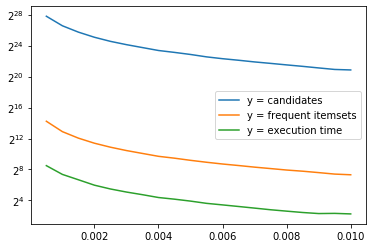

In [22]:
can_list, freq_list, exec_time_list, min_sup_values = sensitivity_analysis()

#### Plotting graphs individually to infer better. Obtained values from above run stats.

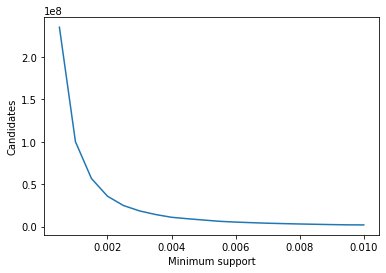

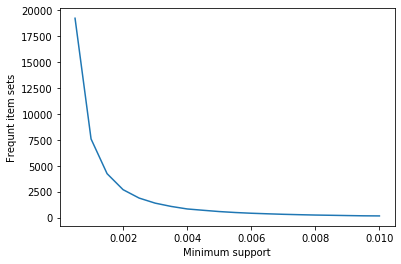

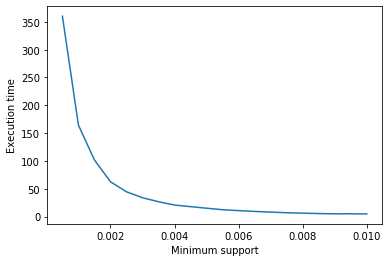

In [23]:
x = np.array(min_sup_values)
y_values = [can_list,freq_list,exec_time_list]
labels = ['Candidates', 'Frequnt item sets', 'Execution time']
for i in range(0,len(y_values)):
    plt.plot(x, np.array(y_values[i]))
    plt.xlabel('Minimum support')
    plt.ylabel(labels[i])
    plt.show()